<a href="https://colab.research.google.com/github/aliyassine1/LiteMedSAM_quant/blob/main/APIs_Backend_and_deployment_modelBit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone -b LiteMedSAM https://github.com/bowang-lab/MedSAM/

fatal: destination path 'MedSAM' already exists and is not an empty directory.


In [ ]:
cd /content/drive/MyDrive/challenge_medsam/MedSAM_fast

/content/drive/MyDrive/challenge_medsam/MedSAM_fast


In [ ]:
pip install timm

In [ ]:
from os import listdir, makedirs
from os.path import join, isfile, basename
from glob import glob
from tqdm import tqdm
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from segment_anything.modeling import MaskDecoder, PromptEncoder, TwoWayTransformer
from tiny_vit_sam import TinyViT
from matplotlib import pyplot as plt
import cv2
import argparse
from collections import OrderedDict
import pandas as pd

# medsamlite
class MedSAM_Lite(nn.Module):
    def __init__(
            self,
            image_encoder,
            mask_decoder,
            prompt_encoder
        ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

    def forward(self, image, box_np):
        image_embedding = self.image_encoder(image) # (B, 256, 64, 64)
        # do not compute gradients for prompt encoder
        with torch.no_grad():
            box_torch = torch.as_tensor(box_np, dtype=torch.float32, device=image.device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)

        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None,
            boxes=box_np,
            masks=None,
        )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding, # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          ) # (B, 1, 256, 256)

        return low_res_masks

    @torch.no_grad()
    def postprocess_masks(self, masks, new_size, original_size):
        """
        Do cropping and resizing

        Parameters
        ----------
        masks : torch.Tensor
            masks predicted by the model
        new_size : tuple
            the shape of the image after resizing to the longest side of 256
        original_size : tuple
            the original shape of the image

        Returns
        -------
        torch.Tensor
            the upsampled mask to the original size
        """
        # Crop
        masks = masks[..., :new_size[0], :new_size[1]]
        # Resize
        masks = F.interpolate(
            masks,
            size=(original_size[0], original_size[1]),
            mode="bilinear",
            align_corners=False,
        )

        return masks


In [ ]:
import time
import numpy as np
from skimage import transform, io

from torch.nn import functional as F
from PIL import Image
from segment_anything import sam_model_registry
from os import listdir, makedirs
from os.path import join, isfile, basename
from glob import glob
from tqdm import tqdm
# wrap it up as a function
import base64

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tiny_vit_sam import TinyViT
from segment_anything.modeling import MaskDecoder, PromptEncoder, TwoWayTransformer
#from tiny_vit_sam import TinyViT
from matplotlib import pyplot as plt
import cv2
import argparse
from collections import OrderedDict
import pandas as pd
import torch.nn.functional as F


# freeze seeds
torch.manual_seed(2023)
torch.cuda.empty_cache()
torch.cuda.manual_seed(2023)
np.random.seed(2023)


device = "cpu"


def set_up_model():
  # set up model
      medsam_lite_image_encoder = TinyViT(
          img_size=256,
          in_chans=3,
          embed_dims=[
              64, ## (64, 256, 256)
              128, ## (128, 128, 128)
              160, ## (160, 64, 64)
              320 ## (320, 64, 64)
          ],
          depths=[2, 2, 6, 2],
          num_heads=[2, 4, 5, 10],
          window_sizes=[7, 7, 14, 7],
          mlp_ratio=4.,
          drop_rate=0.,
          drop_path_rate=0.0,
          use_checkpoint=False,
          mbconv_expand_ratio=4.0,
          local_conv_size=3,
          layer_lr_decay=0.8
      )

      medsam_lite_prompt_encoder = PromptEncoder(
          embed_dim=256,
          image_embedding_size=(64, 64),
          input_image_size=(256, 256),
          mask_in_chans=16
      )

      medsam_lite_mask_decoder = MaskDecoder(
          num_multimask_outputs=3,
              transformer=TwoWayTransformer(
                  depth=2,
                  embedding_dim=256,
                  mlp_dim=2048,
                  num_heads=8,
              ),
              transformer_dim=256,
              iou_head_depth=3,
              iou_head_hidden_dim=256,
      )

      medsam_model = MedSAM_Lite(
          image_encoder = medsam_lite_image_encoder,
          mask_decoder = medsam_lite_mask_decoder,
          prompt_encoder = medsam_lite_prompt_encoder
      )
      return medsam_model

def postprocess_masks(self, masks, new_size, original_size):
    """
    Do cropping and resizing

    Parameters
    ----------
    masks : torch.Tensor
        masks predicted by the model
    new_size : tuple
        the shape of the image after resizing to the longest side of 256
    original_size : tuple
        the original shape of the image

    Returns
    -------
    torch.Tensor
        the upsampled mask to the original size
    """
    # Crop
    masks = masks[..., :new_size[0], :new_size[1]]
    # Resize
    masks = F.interpolate(
        masks,
        size=(original_size[0], original_size[1]),
        mode="bilinear",
        align_corners=False,
    )

    return masks

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_256, new_size, original_size):
    box_torch = torch.as_tensor(box_256, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points = None,
        boxes = box_torch,
        masks = None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False
    )

    low_res_pred = medsam_model.postprocess_masks(low_res_logits, new_size, original_size)
    low_res_pred = torch.sigmoid(low_res_pred)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)

    return medsam_seg



def resize_longest_side(image, target_length=256):
    """
    Resize image to target_length while keeping the aspect ratio
    Expects a numpy array with shape HxWxC in uint8 format.
    """
    oldh, oldw = image.shape[0], image.shape[1]
    scale = target_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww, newh = int(neww + 0.5), int(newh + 0.5)
    target_size = (neww, newh)

    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def pad_image(image, target_size=256):
    """
    Pad image to target_size
    Expects a numpy array with shape HxWxC in uint8 format.
    """
    # Pad
    h, w = image.shape[0], image.shape[1]
    padh = target_size - h
    padw = target_size - w
    if len(image.shape) == 3: ## Pad image
        image_padded = np.pad(image, ((0, padh), (0, padw), (0, 0)))
    else: ## Pad gt mask
        image_padded = np.pad(image, ((0, padh), (0, padw)))

    return image_padded

def load_image(img_np,medsam_model):


    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    assert np.max(img_3c)<256, f'input data should be in range [0, 255], but got {np.unique(img_3c)}'
    H, W, _ = img_3c.shape

    #segs = np.zeros(img_3c.shape[:2], dtype=np.uint8)

    segs = np.zeros(img_3c.shape[:2], dtype=np.uint8)

    ## MedSAM Lite preprocessing
    img_256 = resize_longest_side(img_3c, 256)
    newh, neww = img_256.shape[:2]
    img_256_norm = (img_256 - img_256.min()) / np.clip(
        img_256.max() - img_256.min(), a_min=1e-8, a_max=None
    )
    ## preprocessing
    #img_256 = resize_longest_side(img_3c, 256)
    #newh, neww = img_256.shape[:2]
    img_256_padded = pad_image(img_256_norm, 256)
    img_256_tensor = torch.tensor(img_256_padded).float().permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_256_tensor)

    return img_3c,image_embedding,H, W,newh, neww



def save_mask(self):
    out_path = f"{self.image_path.split('.')[0]}_mask.png"
    io.imsave(out_path, self.mask_c)

In [ ]:
lite_medsam_checkpoint_path="/content/drive/MyDrive/challenge_medsam/MedSAM_fast/work_dir/LiteMedSAM/lite_medsam.pth"
medsam_model=set_up_model()
print("Loading MedSAM model, a sec.")
tic = time.perf_counter()
lite_medsam_checkpoint = torch.load(lite_medsam_checkpoint_path, map_location='cpu')
medsam_model.load_state_dict(lite_medsam_checkpoint)
medsam_model.to(device)
medsam_model.eval

print(f"Done, took {time.perf_counter() - tic} to load the model")

Loading MedSAM model, a sec.
Done, took 0.09868765200008056 to load the model


In [ ]:
import base64


# Function to convert a PIL Image to base64 using OpenCV
def pil_image_to_base64(pil_img):
    # Convert PIL Image to NumPy array
    np_img = np.array(pil_img)

    # Convert RGB to BGR (OpenCV uses BGR color order)
    np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)

    # Encode the image as PNG
    _, buffer = cv2.imencode('.png', np_img)

    # Convert to bytes and then to base64 string
    base64_str = base64.b64encode(buffer).decode('utf-8')

    return base64_str

def apply_segmentation_and_blend(image_base64_encoding, coordinates):
    """
    Decodes a base64 encoded image, applies segmentation on a specified area of the image,
    and blends the segmentation mask with the original image.

    Parameters:
    - image_base64_encoding: Base64 encoded string of the image file.
    - coordinates: A tuple or list of (xmin, ymin, xmax, ymax) specifying the bounding box.

    Returns:
    - bg: The original image as a PIL Image object.
    - mask: The segmentation mask as a PIL Image object.
    - blended_image: The blended image as a PIL Image object.
    """
    # Decode the base64 string to get the image bytes
    image_bytes = base64.b64decode(image_base64_encoding)

    # Convert bytes to an image array
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)

    # Check if the image was correctly loaded
    if image is None:
        raise ValueError("The image could not be decoded from base64. Please check the encoding.")

    # Process the image
    img_3c,image_embedding,H, W,newh, neww= load_image(image, medsam_model)

    # Convert coordinates to the model's input scale
    xmin, ymin, xmax, ymax = coordinates
    box_np = np.array([[xmin, ymin, xmax, ymax]])
    box_256 = box_np / np.array([W, H, W, H]) * 256

    # Perform inference to get the segmentation mask
    sam_mask = medsam_inference(medsam_model, image_embedding, box_256,  (newh, neww), (H, W))

    # Prepare mask with a vibrant color
    mask_c = np.zeros((H, W, 3), dtype="uint8")
    vibrant_color = (0, 255, 255)
    mask_c[sam_mask != 0] = vibrant_color

    # Convert to PIL Images for blending
    bg = Image.fromarray(img_3c.astype("uint8"), "RGB")
    mask = Image.fromarray(mask_c.astype("uint8"), "RGB")
    blend_factor = 0.4
    blended_image = Image.blend(bg, mask, blend_factor)


    # Assuming bg, mask, and blended_image are already created as PIL Image objects
    bg_base64 = pil_image_to_base64(bg)
    mask_base64 = pil_image_to_base64(mask)
    # Blend the original image with the mask using a blend factor
    blended_image_base64 = pil_image_to_base64(blended_image)

    return bg_base64, mask_base64, blended_image_base64


In [ ]:
import cv2
import numpy as np
from PIL import Image
import base64
import io

# Assuming medsam_model and medsam_inference are defined and initialized elsewhere


def give_mask(image_base64_encoding, coordinates,color):
    """
    Decodes a base64 encoded image, applies segmentation on a specified area of the image,
    and blends the segmentation mask with the original image.

    Parameters:
    - image_base64_encoding: Base64 encoded string of the image file.
    - coordinates: A tuple or list of (xmin, ymin, xmax, ymax) specifying the bounding box.

    Returns:
    - bg: The original image as a PIL Image object.
    - mask: The segmentation mask as a PIL Image object.
    - blended_image: The blended image as a PIL Image object.
    """
    # Decode the base64 string to get the image bytes
    image_bytes = base64.b64decode(image_base64_encoding)

    # Convert bytes to an image array
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)

    # Check if the image was correctly loaded
    if image is None:
        raise ValueError("The image could not be decoded from base64. Please check the encoding.")

    # Process the image
    img_3c,image_embedding,H, W,newh, neww= load_image(image, medsam_model)

    # Convert coordinates to the model's input scale
    xmin, ymin, xmax, ymax = coordinates
    box_np = np.array([[xmin, ymin, xmax, ymax]])
    box_256 = box_np / np.array([W, H, W, H]) * 256

    # Perform inference to get the segmentation mask
    sam_mask = medsam_inference(medsam_model, image_embedding, box_256,  (newh, neww), (H, W))

    mask_c = np.zeros((H, W, 3), dtype="uint8")
    mask_c[sam_mask != 0] = color

    mask = Image.fromarray(mask_c.astype("uint8"), "RGB")

    mask_base64 = pil_image_to_base64(mask)
    # Return only the mask
    return mask_base64




def apply_segmentation_and_blend_multiple_boxes(image_base64_encoding, bounding_boxes):
    # Decode the base64 string to get the image bytes and convert to a PIL Image
    image_bytes = base64.b64decode(image_base64_encoding)
    bg = Image.open(io.BytesIO(image_bytes))

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

    # Create and save masks for each bounding box
    mask_list = []
    for i, box in enumerate(bounding_boxes):
        color = colors[i % len(colors)]
        mask_base64 = give_mask(
            image_base64_encoding, box, color,
        )
        mask_list.append(mask_base64)

    return mask_list





API testing:

API 1

<ipython-input-15-b786b9fa7034>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


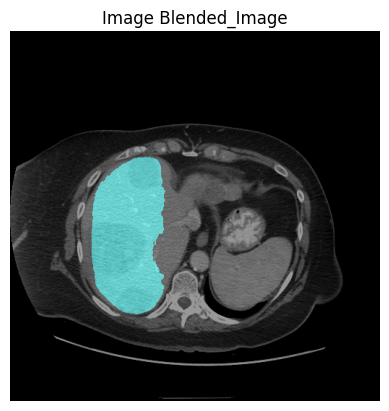

In [ ]:
from imageio import imread
# Function to decode and display a base64 encoded image
def display_base64_encoded_image(base64_string, title="Image"):
    # Decode the base64 string
    img_data = base64.b64decode(base64_string)

    # Convert the bytes data to a numpy array
    nparr = np.frombuffer(img_data, np.uint8)

    # Decode the numpy array to an image
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert BGR to RGB (Matplotlib displays images in RGB format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  # Do not show axis to keep it clean
    plt.show()


image_title=["Background","Mask","Blended_Image"]

image_path = '/content/img_demo.png'


#image = cv2.imread(image_path)
image = imread(image_path)
_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
#[{'x': 112, 'y': 158}, {'x': 225, 'y': 398}]
#coordinates = (31,  53,585, 662)
coordinates = (112, 158,225, 398)
bg_base64, mask_base64, blended_image_base64=apply_segmentation_and_blend(image_bytes_encoded_base64, coordinates)

display_base64_encoded_image(blended_image_base64, f"Image {image_title[2]}")


API 2

<ipython-input-16-90540c0299c2>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


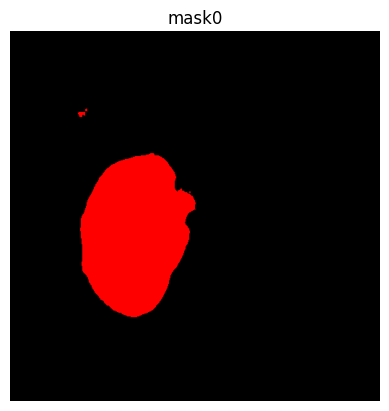

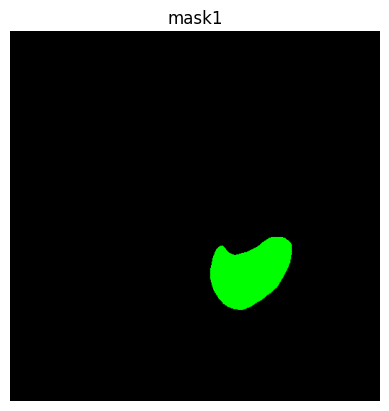

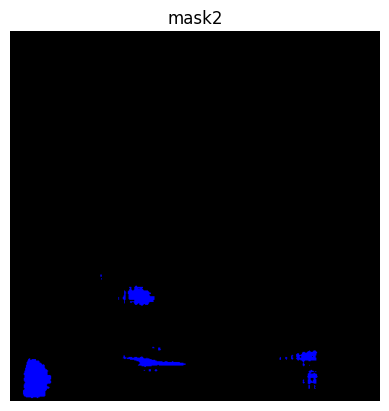

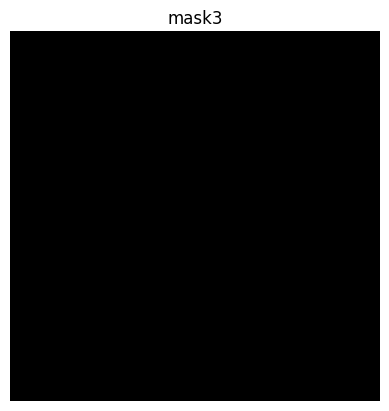

In [ ]:
from imageio import imread
image_title=["Background","Mask","Blended_Image"]

image_path = '/content/img_demo.png'

image = imread(image_path)

_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
coordinates = [(23,  49,275, 444), (270, 247, 402, 397),(4,302,432,11),(50,70,22,44)]

mask_list=apply_segmentation_and_blend_multiple_boxes(image_bytes_encoded_base64, coordinates)
for i in range(len(mask_list)):
  display_base64_encoded_image(mask_list[i], f"mask{i}")


Faster inference using post traning quantization

In [ ]:
from torch.quantization import quantize_dynamic
lite_medsam_checkpoint_path="/content/drive/MyDrive/challenge_medsam/MedSAM_fast/work_dir/LiteMedSAM/lite_medsam.pth"
medsam_model=set_up_model()

lite_medsam_checkpoint = torch.load(lite_medsam_checkpoint_path, map_location=device)
medsam_model.load_state_dict(lite_medsam_checkpoint)


# Apply dynamic quantization on CPU
medsam_model = quantize_dynamic(
    medsam_model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

medsam_model.to(device)

# Set model to evaluation mode
medsam_model.eval()

In [ ]:
def apply_segmentation_and_blend_fast(image_base64_encoding, coordinates):
    """
    Decodes a base64 encoded image, applies segmentation on a specified area of the image,
    and blends the segmentation mask with the original image.

    Parameters:
    - image_base64_encoding: Base64 encoded string of the image file.
    - coordinates: A tuple or list of (xmin, ymin, xmax, ymax) specifying the bounding box.

    Returns:
    - bg: The original image as a PIL Image object.
    - mask: The segmentation mask as a PIL Image object.
    - blended_image: The blended image as a PIL Image object.
    """
    # Decode the base64 string to get the image bytes
    image_bytes = base64.b64decode(image_base64_encoding)

    # Convert bytes to an image array
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)

    # Check if the image was correctly loaded
    if image is None:
        raise ValueError("The image could not be decoded from base64. Please check the encoding.")

    # Process the image
    img_3c,image_embedding,H, W,newh, neww= load_image(image, medsam_model)

    # Convert coordinates to the model's input scale
    xmin, ymin, xmax, ymax = coordinates
    box_np = np.array([[xmin, ymin, xmax, ymax]])
    box_256 = box_np / np.array([W, H, W, H]) * 256

    # Perform inference to get the segmentation mask
    sam_mask = medsam_inference(medsam_model, image_embedding, box_256,  (newh, neww), (H, W))

    # Prepare mask with a vibrant color
    mask_c = np.zeros((H, W, 3), dtype="uint8")
    vibrant_color = (0, 255, 255)
    mask_c[sam_mask != 0] = vibrant_color

    # Convert to PIL Images for blending
    bg = Image.fromarray(img_3c.astype("uint8"), "RGB")
    mask = Image.fromarray(mask_c.astype("uint8"), "RGB")
    blend_factor = 0.4
    blended_image = Image.blend(bg, mask, blend_factor)


    # Assuming bg, mask, and blended_image are already created as PIL Image objects
    bg_base64 = pil_image_to_base64(bg)
    mask_base64 = pil_image_to_base64(mask)
    # Blend the original image with the mask using a blend factor
    blended_image_base64 = pil_image_to_base64(blended_image)

    return bg_base64, mask_base64, blended_image_base64


In [ ]:
import cv2
import numpy as np
from PIL import Image
import base64
import io

# Assuming medsam_model and medsam_inference are defined and initialized elsewhere


def get_mask_fast(image_base64_encoding, coordinates,color):
    """
    Decodes a base64 encoded image, applies segmentation on a specified area of the image,
    and blends the segmentation mask with the original image.

    Parameters:
    - image_base64_encoding: Base64 encoded string of the image file.
    - coordinates: A tuple or list of (xmin, ymin, xmax, ymax) specifying the bounding box.

    Returns:
    - bg: The original image as a PIL Image object.
    - mask: The segmentation mask as a PIL Image object.
    - blended_image: The blended image as a PIL Image object.
    """
    # Decode the base64 string to get the image bytes
    image_bytes = base64.b64decode(image_base64_encoding)

    # Convert bytes to an image array
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)

    # Check if the image was correctly loaded
    if image is None:
        raise ValueError("The image could not be decoded from base64. Please check the encoding.")

    # Process the image
    img_3c,image_embedding,H, W,newh, neww= load_image(image, medsam_model)

    # Convert coordinates to the model's input scale
    xmin, ymin, xmax, ymax = coordinates
    box_np = np.array([[xmin, ymin, xmax, ymax]])
    box_256 = box_np / np.array([W, H, W, H]) * 256

    # Perform inference to get the segmentation mask
    sam_mask = medsam_inference(medsam_model, image_embedding, box_256,  (newh, neww), (H, W))

    mask_c = np.zeros((H, W, 3), dtype="uint8")
    mask_c[sam_mask != 0] = color

    mask = Image.fromarray(mask_c.astype("uint8"), "RGB")

    mask_base64 = pil_image_to_base64(mask)
    # Return only the mask
    return mask_base64




def apply_segmentation_and_blend_fast_multiple_boxes(image_base64_encoding, bounding_boxes):
    # Decode the base64 string to get the image bytes and convert to a PIL Image
    image_bytes = base64.b64decode(image_base64_encoding)
    bg = Image.open(io.BytesIO(image_bytes))

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

    # Create and save masks for each bounding box
    mask_list = []
    for i, box in enumerate(bounding_boxes):
        color = colors[i % len(colors)]
        mask_base64 = get_mask_fast(
            image_base64_encoding, box, color,
        )
        mask_list.append(mask_base64)

    return mask_list





API testing

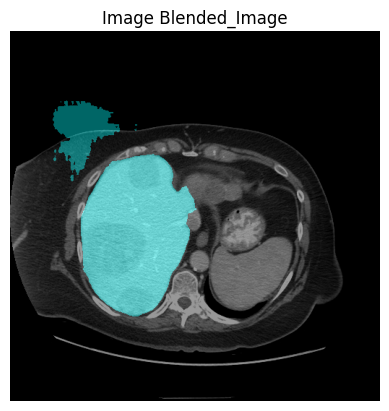

In [ ]:

# Function to decode and display a base64 encoded image
def display_base64_encoded_image(base64_string, title="Image"):
    # Decode the base64 string
    img_data = base64.b64decode(base64_string)

    # Convert the bytes data to a numpy array
    nparr = np.frombuffer(img_data, np.uint8)

    # Decode the numpy array to an image
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert BGR to RGB (Matplotlib displays images in RGB format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  # Do not show axis to keep it clean
    plt.show()


image_title=["Background","Mask","Blended_Image"]

image_path = '/content/img_demo.png'


image = io.imread(image_path)

_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
coordinates = (23,  49,275, 444)
#coordinates = (3,  1,767, 521)
bg_base64, mask_base64, blended_image_base64=apply_segmentation_and_blend_fast(image_bytes_encoded_base64, coordinates)

display_base64_encoded_image(blended_image_base64, f"Image {image_title[2]}")


<ipython-input-77-28937daba26f>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_path)


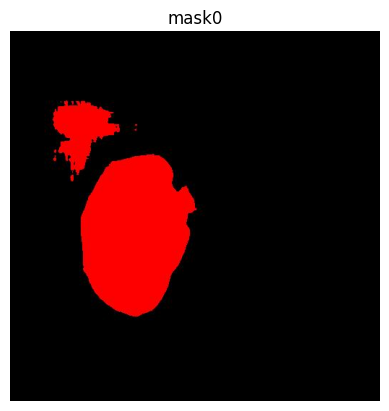

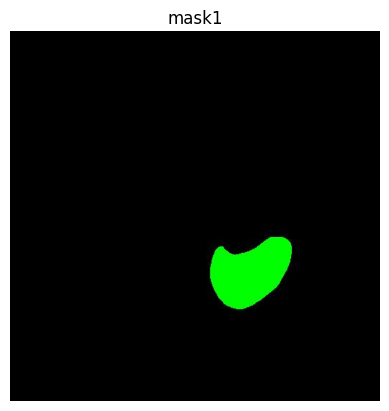

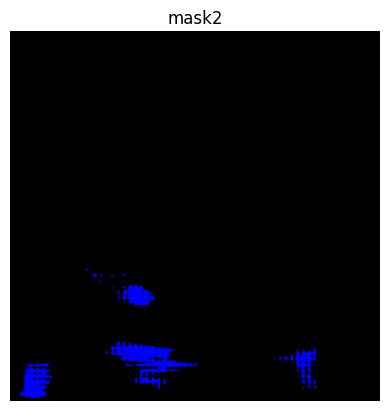

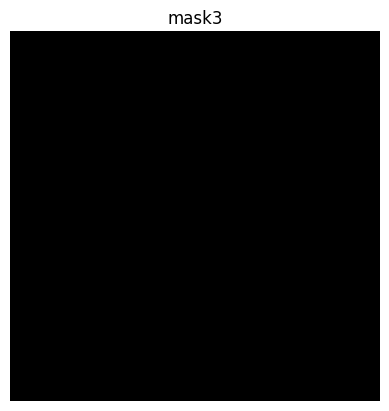

In [ ]:
from imageio import imread
image_title=["Background","Mask","Blended_Image"]

image_path = '/content/img_demo.png'

image = imread(image_path)

_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
coordinates = [(23,  49,275, 444), (270, 247, 402, 397),(4,302,432,11),(50,70,22,44)]

mask_list=apply_segmentation_and_blend_fast_multiple_boxes(image_bytes_encoded_base64, coordinates)
for i in range(len(mask_list)):
  display_base64_encoded_image(mask_list[i], f"mask{i}")


**Deployement to ModelBit - REST API**

In [ ]:
import modelbit
mb = modelbit.login()

In [ ]:
mb.deploy(apply_segmentation_and_blend, python_packages=[
    "git+https://github.com/bowang-lab/MedSAM.git@LiteMedSAM"],extra_files={ "/content/MedSAM/tiny_vit_sam.py": "tiny_vit_sam.py" })

Uploading 'medsam_model': 100%|██████████| 36.5M/36.5M [00:04<00:00, 8.55MB/s]


In [ ]:
mb.deploy(apply_segmentation_and_blend_fast, python_packages=[
    "git+https://github.com/bowang-lab/MedSAM.git@LiteMedSAM"],extra_files={ "/content/MedSAM/tiny_vit_sam.py": "tiny_vit_sam.py" })

In [ ]:
mb.deploy(apply_segmentation_and_blend_multiple_boxes, python_packages=[
    "git+https://github.com/bowang-lab/MedSAM.git@LiteMedSAM"],"/content/MedSAM/tiny_vit_sam.py": "tiny_vit_sam.py" )

In [ ]:
mb.deploy(apply_segmentation_and_blend_fast_multiple_boxes, python_packages=[
    "git+https://github.com/bowang-lab/MedSAM.git@LiteMedSAM"],"/content/MedSAM/tiny_vit_sam.py": "tiny_vit_sam.py" )

API testing via requests.

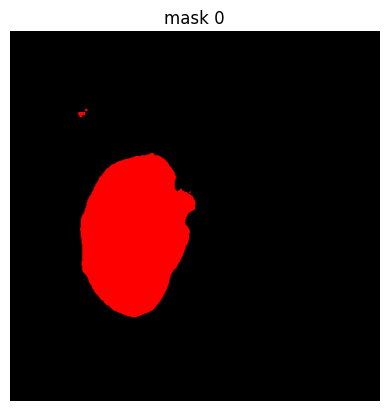

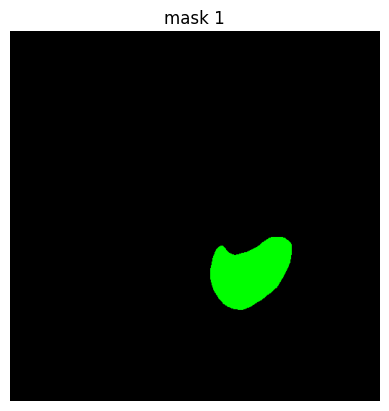

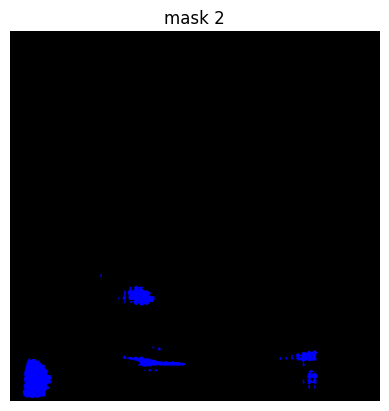

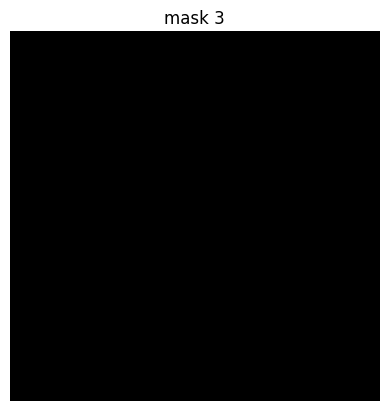

In [ ]:
import os
import base64
import numpy as np
import cv2
import requests
from matplotlib import pyplot as plt


# Function to decode and display a base64 encoded image
def display_base64_encoded_image(base64_string, title="Image"):
    # Decode the base64 string
    img_data = base64.b64decode(base64_string)

    # Convert the bytes data to a numpy array
    nparr = np.frombuffer(img_data, np.uint8)

    # Decode the numpy array to an image
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert BGR to RGB (Matplotlib displays images in RGB format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  # Do not show axis to keep it clean
    plt.show()


image_title=["Background","Mask","Blended_Image"]

api_endpoint = "https://ay.us-east-1.modelbit.com/v1/apply_segmentation_and_blend_multiple_boxes/latest"
image_path = '/content/img_demo.png'

# Ensure the image exists
if not os.path.exists(image_path):
    # Replace 'your-image-url' with the actual URL of the image you want to download
    os.system(f"wget https://your-image-url -O {image_path}")

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
coordinates = [(23,  49,275, 444), (270, 247, 402, 397),(4,302,432,11),(50,70,22,44)]
api_data = {"data": [image_bytes_encoded_base64, coordinates]}

response = requests.post(api_endpoint, json=api_data)

# Handle the API response
if response.status_code == 200:
    result_json = response.json()['data']

    # Assuming the API response is a list of base64 strings: [bg_base64, mask_base64, blended_image_base64]
    for i in range(0,len(result_json)):
        display_base64_encoded_image(result_json[i], f"mask {i}")
else:
    print(f"Failed to get a response from the API: {response.status_code}", response.text)

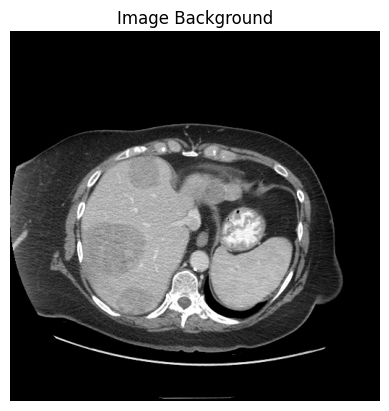

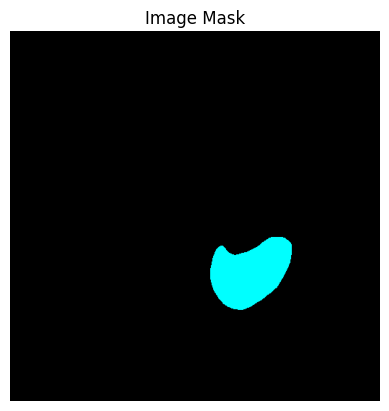

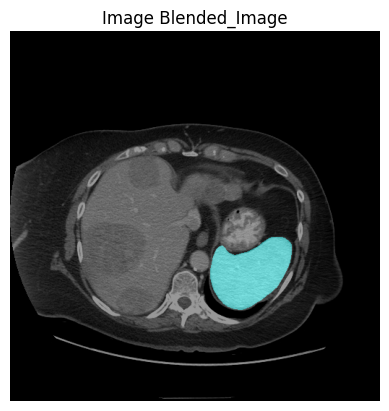

In [ ]:
import os
import base64
import numpy as np
import cv2
import requests
from matplotlib import pyplot as plt


# Function to decode and display a base64 encoded image
def display_base64_encoded_image(base64_string, title="Image"):
    # Decode the base64 string
    img_data = base64.b64decode(base64_string)

    # Convert the bytes data to a numpy array
    nparr = np.frombuffer(img_data, np.uint8)

    # Decode the numpy array to an image
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert BGR to RGB (Matplotlib displays images in RGB format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  # Do not show axis to keep it clean
    plt.show()


image_title=["Background","Mask","Blended_Image"]

api_endpoint = "https://ay.us-east-1.modelbit.com/v1/apply_segmentation_and_blend/latest"
image_path = '/content/img_demo.png'

# Ensure the image exists
if not os.path.exists(image_path):
    # Replace 'your-image-url' with the actual URL of the image you want to download
    os.system(f"wget https://your-image-url -O {image_path}")

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
coordinates = [270, 247, 402, 397]
api_data = {"data": [image_bytes_encoded_base64, coordinates]}

response = requests.post(api_endpoint, json=api_data)

# Handle the API response
if response.status_code == 200:
    result_json = response.json()['data']

    # Assuming the API response is a list of base64 strings: [bg_base64, mask_base64, blended_image_base64]
    for i, img_base64 in enumerate(result_json):
        display_base64_encoded_image(img_base64, f"Image {image_title[i]}")
else:
    print(f"Failed to get a response from the API: {response.status_code}", response.text)

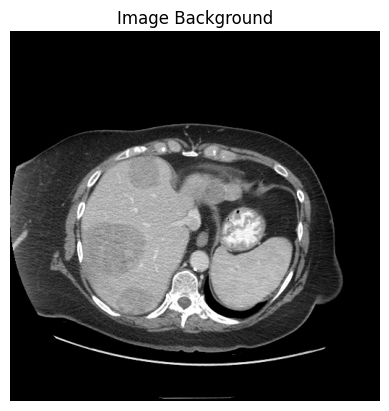

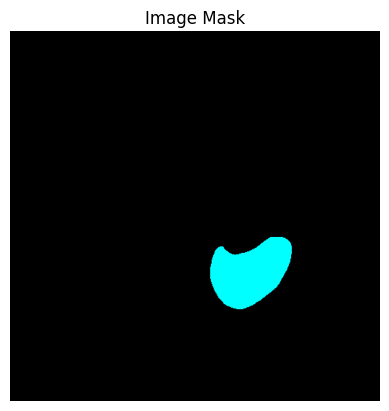

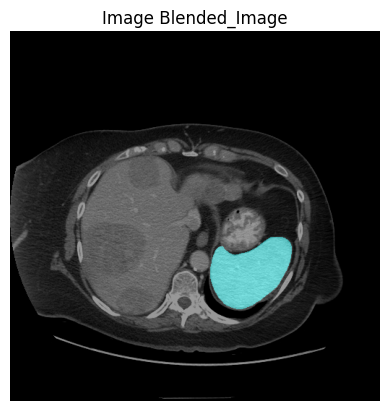

In [ ]:
import os
import base64
import numpy as np
import cv2
import requests
from matplotlib import pyplot as plt


# Function to decode and display a base64 encoded image
def display_base64_encoded_image(base64_string, title="Image"):
    # Decode the base64 string
    img_data = base64.b64decode(base64_string)

    # Convert the bytes data to a numpy array
    nparr = np.frombuffer(img_data, np.uint8)

    # Decode the numpy array to an image
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert BGR to RGB (Matplotlib displays images in RGB format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  # Do not show axis to keep it clean
    plt.show()


image_title=["Background","Mask","Blended_Image"]

api_endpoint = "https://ay.us-east-1.modelbit.com/v1/apply_segmentation_and_blend_fast/latest"
image_path = '/content/img_demo.png'

# Ensure the image exists
if not os.path.exists(image_path):
    # Replace 'your-image-url' with the actual URL of the image you want to download
    os.system(f"wget https://your-image-url -O {image_path}")

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
coordinates = [270, 247, 402, 397]
api_data = {"data": [image_bytes_encoded_base64, coordinates]}

response = requests.post(api_endpoint, json=api_data)

# Handle the API response
if response.status_code == 200:
    result_json = response.json()['data']

    # Assuming the API response is a list of base64 strings: [bg_base64, mask_base64, blended_image_base64]
    for i, img_base64 in enumerate(result_json):
        display_base64_encoded_image(img_base64, f"Image {image_title[i]}")
else:
    print(f"Failed to get a response from the API: {response.status_code}", response.text)

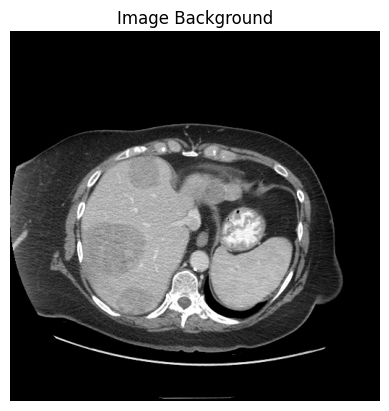

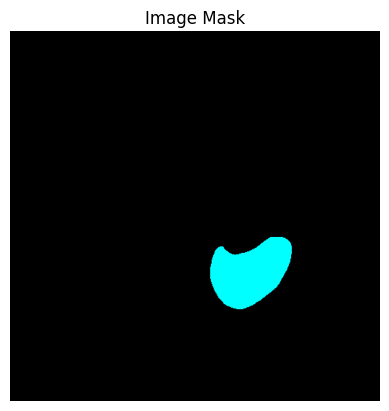

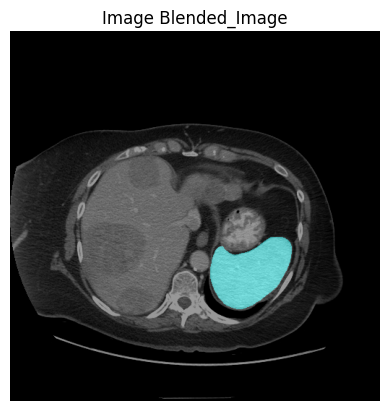

In [ ]:
import os
import base64
import numpy as np
import cv2
import requests
from matplotlib import pyplot as plt


# Function to decode and display a base64 encoded image
def display_base64_encoded_image(base64_string, title="Image"):
    # Decode the base64 string
    img_data = base64.b64decode(base64_string)

    # Convert the bytes data to a numpy array
    nparr = np.frombuffer(img_data, np.uint8)

    # Decode the numpy array to an image
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert BGR to RGB (Matplotlib displays images in RGB format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  # Do not show axis to keep it clean
    plt.show()


image_title=["Background","Mask","Blended_Image"]

api_endpoint = "https://ay.us-east-1.modelbit.com/v1/apply_segmentation_and_blend_fast/latest"
image_path = '/content/img_demo.png'

# Ensure the image exists
if not os.path.exists(image_path):
    # Replace 'your-image-url' with the actual URL of the image you want to download
    os.system(f"wget https://your-image-url -O {image_path}")

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.jpg', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

# Prepare the API request data
coordinates = [270, 247, 402, 397]
api_data = {"data": [image_bytes_encoded_base64, coordinates]}

response = requests.post(api_endpoint, json=api_data)

# Handle the API response
if response.status_code == 200:
    result_json = response.json()['data']

    # Assuming the API response is a list of base64 strings: [bg_base64, mask_base64, blended_image_base64]
    for i, img_base64 in enumerate(result_json):
        display_base64_encoded_image(img_base64, f"Image {image_title[i]}")
else:
    print(f"Failed to get a response from the API: {response.status_code}", response.text)